# Spreading processes in networks

## Configuration of the runtime

In [ ]:
! pip install ndlib
! apt install libgraphviz-dev # or brew install libgraphviz # for windows users - do not use windows
! pip install pygraphviz

In [2]:
import json
import os
import random
import requests
import sys
from pathlib import Path
from typing import Any, Dict, List, Tuple

sys.path.append(os.getcwd())

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from ndlib.models import ModelConfig
from ndlib.models.epidemics import IndependentCascadesModel
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from tqdm.notebook import tqdm

%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [3]:
# do not analyse these functions - they are just to help in visualisations

first_management_level = [86, 7, 27, 36, 69, 70, 85, 104, 121, 148, 156, 163]
second_management_level = [76, 90, 136, 137, 143, 152, 47, 162]


def parse_iterations_status_to_node_colors(iterations_result):
    iteration_nodes_dict = [dict(iterations_result[0]['status']) for _ in range(len(iterations_result))]
    for i, iteration_result in enumerate(iterations_result):
        iteration_nodes_dict[i] = dict(iteration_nodes_dict[i-1])
        for n, v in iteration_result['status'].items():
            iteration_nodes_dict[i][n] = v
    collors_map = {0: 'b', 1: 'r', 2: 'g'}
    node_colors = [[collors_map[d[k]] for k in sorted(d.keys())] for d in iteration_nodes_dict]
    return node_colors


def plot_spreading_process_stages(G, pos, iterations, nr_inter_stages):
    _, axs = plt.subplots(nr_inter_stages+2, 1, figsize=(15, 5*(nr_inter_stages+2)))
    node_colors = np.array(parse_iterations_status_to_node_colors(iterations))
    nx.draw(
        G,
        ax=axs[0],
        pos=pos,
        with_labels=False,
        arrows=True,
        node_size=50,
        edge_color='.5',
        width=0.3,
        node_color=node_colors[0],
    )
    axs[0].set_title(f'Step 0 - Initial State')
    if nr_inter_stages:
        steps_to_plot = np.linspace(1, len(iterations)-1, nr_inter_stages).astype(int)
        for i, s in enumerate(steps_to_plot, 1):
            nx.draw(
                G,
                ax=axs[i],
                pos=pos,
                with_labels=False,
                arrows=True,
                node_size=50,
                edge_color='.5',
                width=0.3, 
                node_color=node_colors[s],
            )
            axs[i].set_title(f'Step {s} - Intermediate State')
    nx.draw(
        G,
        ax=axs[nr_inter_stages+1],
        pos=pos,
        with_labels=False,
        arrows=True,
        node_size=50,
        edge_color='.5',
        width=0.3,
        node_color=node_colors[len(iterations)-1]
    )
    axs[nr_inter_stages+1].set_title(f'Step {len(iterations)-1} - Final State')


def plot_spreading_comparison(G, pos, spreading_results):
    nr_results = len(spreading_results)
    _, axs = plt.subplots(nr_results, 1, figsize=(15, 5*nr_results))
    for i, (name, iterations) in enumerate(spreading_results.items()):
        node_colors = np.array(parse_iterations_status_to_node_colors(iterations))
        nx.draw(
            G,
            ax=axs[i],
            pos=pos,
            with_labels=False,
            arrows=True,
            node_size=50, 
            edge_color='.5',
            width=0.3,
            node_color=node_colors[len(iterations)-1]
        )
        axs[i].set_title(f'Final State - {name}')

## Network import and exploratory data analysis

### Import communication data

Now, let's fetch the data with interactions between employees 

In [4]:
data_file = Path("communication.tab")
if not data_file.exists():
    r = requests.get("https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/6Z3CGX/KWTRDM")
    with open(data_file, "w") as file:
        file.write(r.text.replace('"', ''))

# alternatively download from:
# https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6Z3CGX#

In [5]:
raw_df = pd.read_table(data_file, sep=';', header=0,  parse_dates=["EventDate"])
print(raw_df.dtypes)
print(len(raw_df))
raw_df.head()

Sender                int64
Recipient             int64
EventDate    datetime64[ns]
dtype: object
82927


,Sender,Recipient,EventDate
0,17,37,2010-01-02 17:40:10
1,17,136,2010-01-02 17:40:10
2,17,62,2010-01-02 17:40:10
3,17,129,2010-01-02 17:40:10
4,17,32,2010-01-02 17:40:10


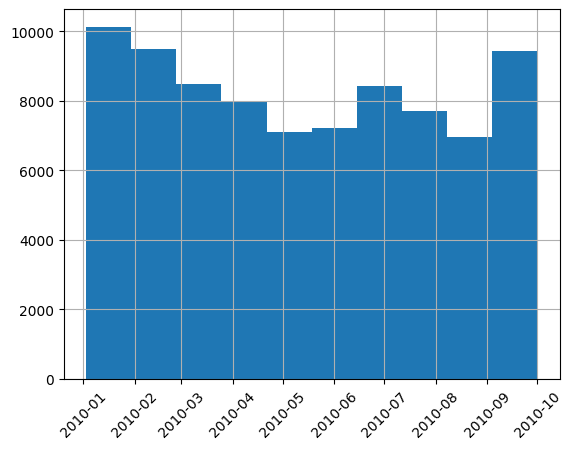

In [6]:
raw_df["EventDate"].hist(xrot=45)
plt.show()

We are going to simulate a spread of the computer virus, hence let's filter out edges and keep only these from last three days of the last month.

In [7]:
raw_df = raw_df.loc[raw_df["EventDate"] > pd.Timestamp("2010-09-27")].reset_index().drop("index", axis=1)
print(raw_df.dtypes)
print(len(raw_df))
raw_df.head()

Sender                int64
Recipient             int64
EventDate    datetime64[ns]
dtype: object
2056


,Sender,Recipient,EventDate
0,16,39,2010-09-27 06:00:34
1,74,90,2010-09-27 06:31:20
2,74,35,2010-09-27 06:31:20
3,74,41,2010-09-27 06:31:20
4,117,101,2010-09-27 06:32:22


### Load another file to visualise the hierachy in the company

There is also another file describing the domain hierarchy in the company. We 
will fetch it, load it and use to visualise simulated processes.

In [8]:
data_file = Path("reportsto.tab")
if not data_file.exists():
    r = requests.get("https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/6Z3CGX/SMALXX")
    with open(data_file, "w") as file:
        file.write(r.text.replace('"', ''))

# alternatively download from:
# https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6Z3CGX#

In [9]:
reportsto = pd.read_csv(data_file, sep=";")
print(reportsto.dtypes)
print(len(reportsto))
reportsto.head()

ID              int64
ReportsToID    object
dtype: object
167


,ID,ReportsToID
0,1,152
1,2,132
2,3,152
3,4,technical email account - not used by employees
4,5,36


Let's note that some nodes are artificial (e.g. nb. 4) - we have to filter them out.

In [10]:
non_employee_accounts = reportsto[reportsto.ReportsToID.apply(lambda x: not x.isnumeric())]
print(non_employee_accounts)

      ID                                      ReportsToID
3      4  technical email account - not used by employees
9     10  technical email account - not used by employees
20    21  technical email account - not used by employees
22    23  technical email account - not used by employees
23    24  technical email account - not used by employees
25    26  technical email account - not used by employees
45    46  technical email account - not used by employees
50    51                          former employee account
74    75                          former employee account
86    87                          former employee account
92    93                          former employee account
110  111                          former employee account
138  139                          former employee account


In [11]:
rows_to_remove = raw_df.loc[raw_df["Sender"].isin(non_employee_accounts["ID"]) | raw_df["Recipient"].isin(non_employee_accounts["ID"])]
print(rows_to_remove)
raw_df = raw_df.drop(rows_to_remove.index)
reportsto = reportsto.drop(non_employee_accounts.index)

      Sender  Recipient           EventDate
918       88         51 2010-09-28 13:26:30
1543      26        121 2010-09-30 07:21:53
1912      88         51 2010-09-30 12:31:34


As one can note, in the dataset many pairs of nodes are connected
through multiple edges, which makes the network too complex. We are going to simplify
it so that each edge between node 'A' and 'B' will be denoted as a ratio of 
messages sent to B by A and a total number of messages sent to B by anyone.

We expect to have following columns in the final DataFrame:
- Sender (a source of the edge, eg. node X)
- Recipient (a target of the edge, eg. node Y)
- NumberOfMessages (number of messages sent by node X to node Y)
- TotalNumberOfMessages (number of messages sent by node X)
- Weight (100 * NumberOfMessages / sum(TotalNumberOfMessages))

Each row is a unique edge represented in the DataFrame

In [41]:
def convert_dataset(raw_df: pd.DataFrame) -> pd.DataFrame:

    counts = raw_df["Sender"].value_counts()
    df = raw_df.groupby(["Sender", "Recipient"], as_index=False).size()
    df = df.rename(columns={"size": "NumberOfMessages"})
    df["TotalNumberOfMessages"] = df["Sender"].apply(lambda x: counts[x])
    df["Weight"] = 100 * df["NumberOfMessages"] / df["TotalNumberOfMessages"].sum()
    return df

df = convert_dataset(raw_df)

print(df.dtypes)
print(len(df))
df.head()

Sender                     int64
Recipient                  int64
NumberOfMessages           int64
TotalNumberOfMessages      int64
Weight                   float64
dtype: object
850


,Sender,Recipient,NumberOfMessages,TotalNumberOfMessages,Weight
0,3,19,1,14,0.003242
1,3,50,1,14,0.003242
2,3,103,1,14,0.003242
3,3,116,1,14,0.003242
4,3,128,5,14,0.016211


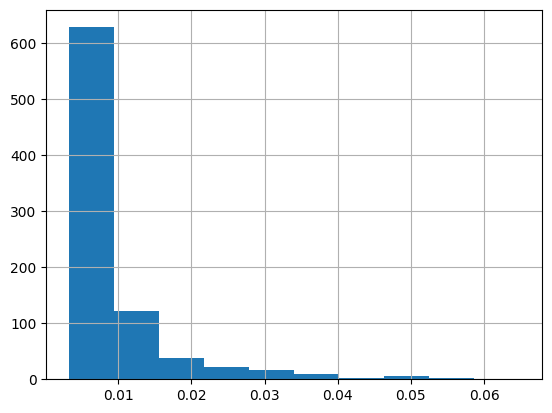

In [13]:
df["Weight"].hist()
plt.show()

### Task 1


**(a) Create a directed network from the graph, count edges and nodes.**

**(b) Compute the network's density. Is the network dense?**

You can use a following [function](https://networkx.org/documentation/stable/auto_examples/drawing/plot_labels_and_colors.html)
from NetworkX.

In [86]:
net = nx.DiGraph()

edges = list(zip(df["Sender"].values.tolist(), df["Recipient"].values.tolist(), df["Weight"].values.tolist()))

net.add_weighted_edges_from(edges)
print(f"Nodes counts: {len(net.nodes)}")
print(f"Edges counts: {len(net.edges)}")
print(f"Network density: {nx.density(net)}")

assert len(net.edges()) == len(df)

Nodes counts: 103
Edges counts: 830
Network density: 0.07900247477631829


The network is not dense (TODO(Jakub Drzewiecki):)

**(c) check whether the network is complex (how many components does it have)**

In [22]:
print(f"Number of connected components: {nx.number_strongly_connected_components(net)}")

Number of connected components: 19


### Task 2


**remove nodes that are not inside the biggest component (from the network and the dataframe)**

In [69]:
biggest_component = max(nx.strongly_connected_components(net), key=len)

df_cleaned = df

nodes = list(net.nodes)
for i in nodes:
    if i not in biggest_component:
        net.remove_node(i)
        df_cleaned.drop(df_cleaned.loc[df_cleaned["Sender"] == i].index, inplace=True)
        df_cleaned.drop(df_cleaned.loc[df_cleaned["Recipient"] == i].index, inplace=True)
df_cleaned.reset_index(inplace=True, drop=True)

In [70]:
print(f"Nodes count: {len(net.nodes())}")
print(f"Edges count: {len(net.edges())}")
print(f"Network's density: {round(nx.density(net), 2)}")

Nodes count: 103
Edges count: 830
Network's density: 0.08


Then we can can visualise the network as follows:

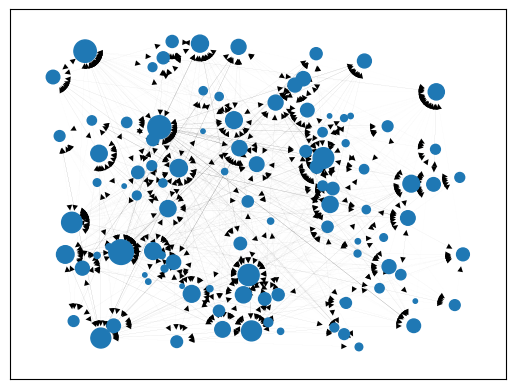

In [71]:
pos_random = nx.layout.random_layout(net)
nx.draw_networkx_edges(net, pos_random, width=[net[u][v]["weight"] for u,v in net.edges()])
nx.draw_networkx_nodes(net, pos_random, node_size=[5 * v for _, v in nx.degree(net)])
plt.show()

Or utilising the domain knowledge:

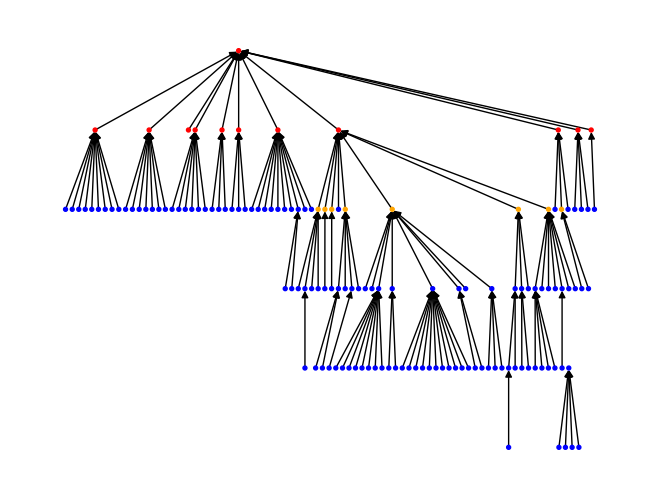

In [72]:
H = nx.DiGraph()

for index, row in reportsto.iterrows():
  employee = row['ID']
  supervisor = int(row['ReportsToID'])
  if employee != supervisor and (employee in net.nodes or supervisor in net.nodes):
    H.add_edge(employee, supervisor)

color_map = []
for node in H:
  if node in first_management_level:
    color_map.append("red")
  elif node in second_management_level:
    color_map.append("orange")
  else:
    color_map.append("blue")

plt.figure()
pos_hierarchic = nx.nx_agraph.graphviz_layout(H, prog='dot')
pos_hierarchic = {node: (x,-y) for (node, (x,y)) in pos_hierarchic.items()}
nx.draw(H, pos=pos_hierarchic, with_labels=False, arrows=True, node_size=8, node_color=color_map)

plt.show()

## Use case a computer virus is being spread through the network

Let's consider a scenario where a group of hackers is plotting to target an 
esteemed IT company using a computer virus that spreads through the email 
exchange. Their strategy is to unleash the computer virus!

The simplest approach would involve randomly sending emails to a large number of
recipients, but the hackers aim to be discreet by limiting their targets to a
select few individuals. However, they are not stopping there. They plan to
employ a more intricate technique by monitoring and intercepting the company's
network traffic over time, enabling them to reconstruct a network graph of 
connections. Armed with this valuable information, the hackers will have the
ability to launch precise and targeted attacks.

We will simulate a spreading of the computer virus with the Independent Cascade 
model. This model is widely used for simulating information diffusion in social
networks. It assumes that influence spreads in a cascading manner, where each 
node has a probability of adopting a behavior based on the influence from its 
neighbors.

The Independent Cascade Model can be simulated as follows:

1. **Input:**
   - Graph $G(V, E)$: Directed graph representing the network topology.
   - Influence probabilities $p(u, v)$: Probability that node $v$ will be influenced by node $u$.
   - Active nodes $A$: Set of initially active nodes.

2. **Initialization:**
   - Set $T = 0$ to represent the current time step.
   - Initialize the set of active nodes at time $T: A(T) = A$.

3. **Propagation:**
   - Repeat until no new nodes become active:
     - For each node $u$ in $A(T)$:
       - For each neighbor $v$ of $u$:
         - If $v$ is not already active and a random number $r \in [0, 1] \leq p(u, v)$:
           - Set $v$ as active in $A(T+1)$.
     - Increment the time step: $T = T + 1$.

4. **Output:**
   - Set of active nodes $A$ at the final time step $T$.


![icm_example.png](icm_example.png)

Please note that in ICM each active node has only one chance to activate its  neighbours.

References:

1. Kempe, D., Kleinberg, J., & Tardos, É. (2003). Maximizing the spread of 
    influence through a social network. In \textit{Proceedings of the ninth 
    ACM SIGKDD international conference on Knowledge discovery and data mining}
    (pp. 137-146).

2. Domingos, P., & Richardson, M. (2001). Mining the network value of customers.
    In \textit{Proceedings of the seventh ACM SIGKDD international conference
    on Knowledge discovery and data mining} (pp. 57-66).

3. "Illustration of the independent cascade model. The decomposition." 
    ResearchGate, 12 June 2023, www.researchgate.net/figure/Illustration-of-the-independent-cascade-model-The-decomposition-diagrams-of-four-time_fig5_369791091.

## Defining a spreading model - ICM

Here is an example how to define ICM with the `NDLib`. Moreover, we can 
visualise the diffusion on the bulk plot an on the network.

In [87]:
model = IndependentCascadesModel(net)
print(f"Available statuses: {model.available_statuses}")

# nodes suspected can be "activated"
# nodes "infected" are active and can activate their neighbours
# nodes "removed" are active but they cannot activate their neighbours anymore

Available statuses: {'Susceptible': 0, 'Infected': 1, 'Removed': 2}


Question: do these names sound familiar to you?

Now let's select some seed nodes!

In [88]:
print(list(net.nodes())[:10])

[3, 19, 50, 103, 116, 128, 132, 143, 166, 11]


In [89]:
# initialise the config class for the model
config = ModelConfig.Configuration()

# add seeds
config.add_model_initial_configuration("Infected", [3, 19, 50])
config.add_model_initial_configuration("Removed", [103, 116, 128])  # what if I point a node that does not exist?

# we can do it as well as follows:
# config.add_model_parameter('fraction_infected', 0.1)

# add the threshold for the nodes
threshold = 0.3  # <- pobawienie się progiem wyższy lepsze pokrycie
for edge in net.edges():
    config.add_edge_configuration("threshold", edge, threshold)

# apply the config to the model
model.set_initial_status(config)

# execute experiment
iterations = model.iteration_bunch(20)  # <- detailed logs from each epoch

In [91]:
# save the detailed logs to investigate what they contain
with open("example_spread_config.json", "w") as file:
    json.dump(iterations, file)

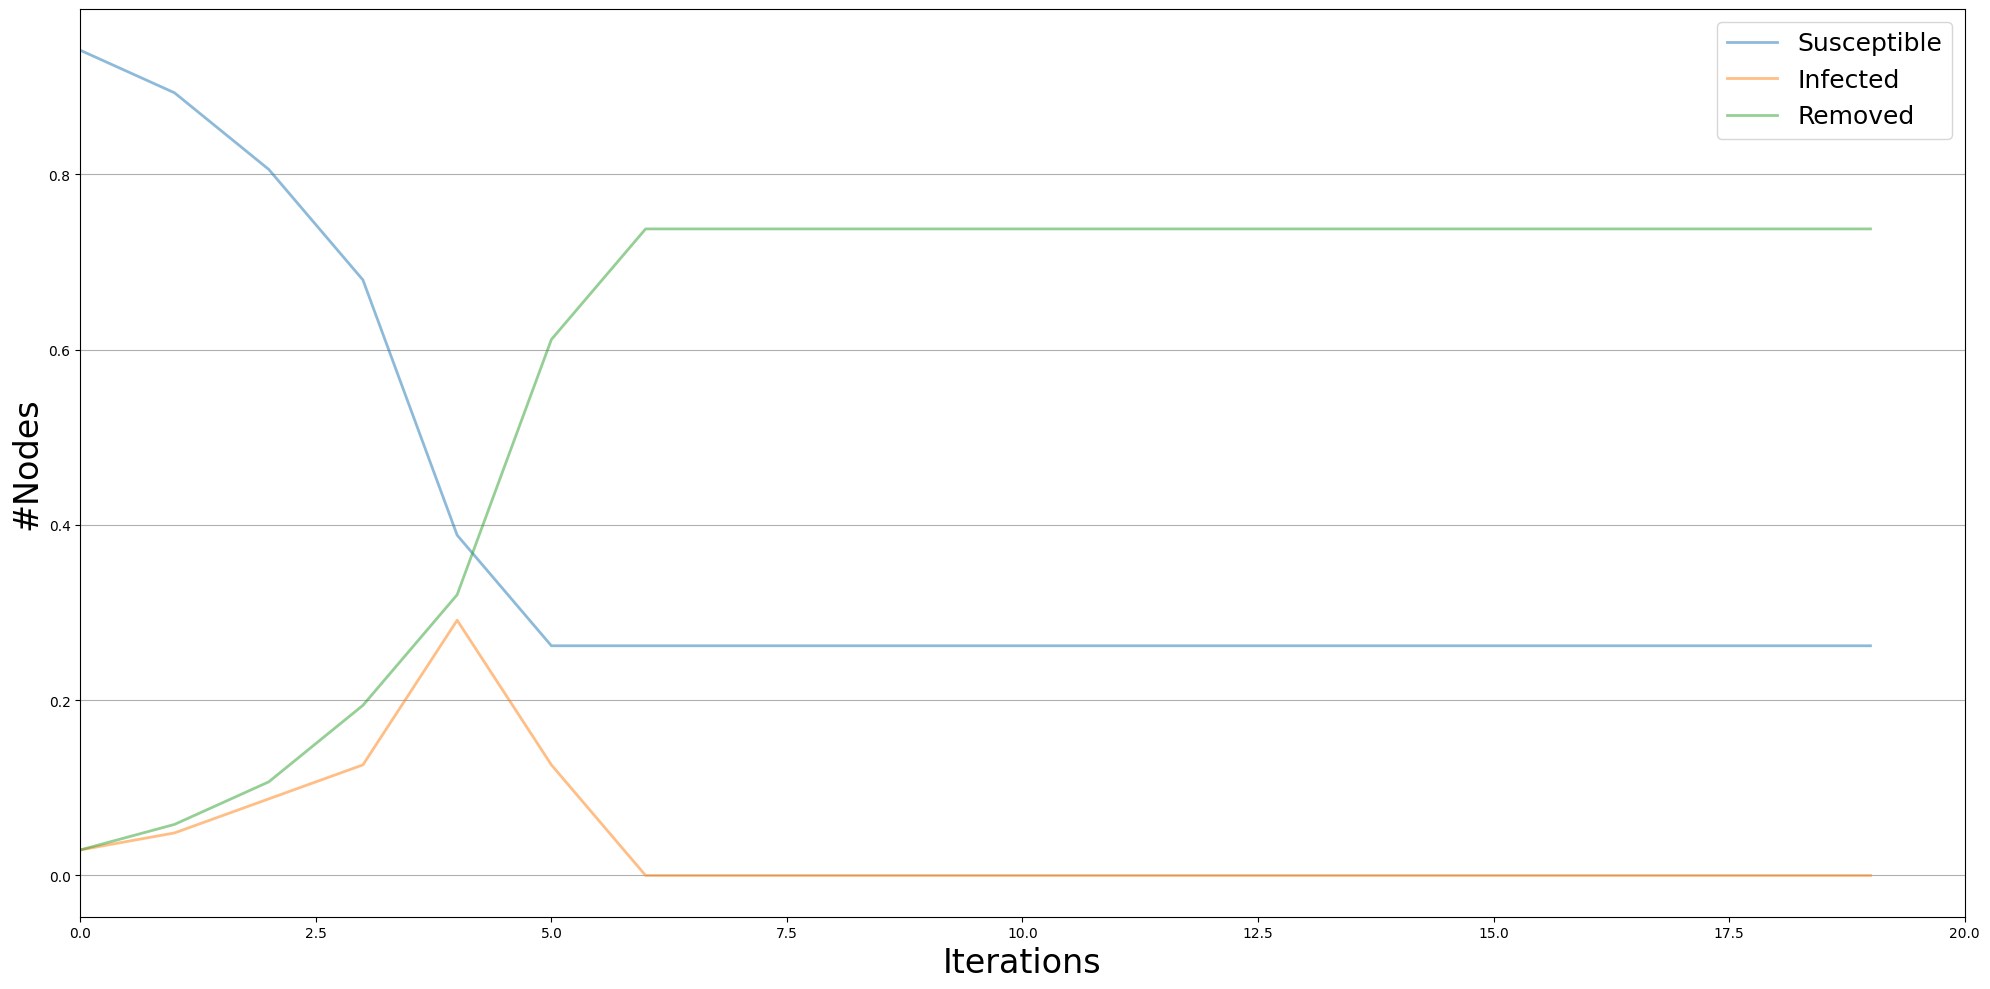

In [92]:
# here is how to plot a bulk chart with matplotlib
trends = model.build_trends(iterations)
DiffusionTrend(model, trends).plot()

In [ ]:
# and here is how to visualise the propagation on the animated plot
plot_spreading_process_stages(net, pos_hierarchic, iterations, 10)

## Creating a pipeline to perform experiments

In [ ]:
def check_config(seed_nodes: List[Any], removed_nodes: List[Any]) -> None:
    """Check whether seed set and set of removed nodes are not overlapping."""
    intersection = len(set(seed_nodes).intersection(set(removed_nodes))) == 0
    assert intersection, f"Overlapping nodes: {intersection}"


def check_nodes(seed_nodes: List[Any], net: nx.Graph):
    """Check if given subset of nodes belongs to the network."""
    intersection = set(seed_nodes).intersection(set(net.nodes()))
    assert len(intersection) == len(seed_nodes), f"Nodes not in the network: {intersection}"

### Task 3

**(a) implement a function `define_model`**

**(b) after you finish the function run it a few times to see that process is stohastic.**

In [ ]:
def define_model(net: nx.Graph, threshold: float, seeds: List[Any], removed: List[Any]) -> IndependentCascadesModel:
    """
    Define ICM model according to given parameters.

    1. check if seed set and set of removed nodes are not overlapping
    2. check if seed set belongs to the network
    3. check if set of removed nodes belongs to the network
    4. create the model
    5. feed the model with configuration (i.e. states of nodes and thresholds in each egde)
    """
    ...

In [ ]:
_model = define_model(net=net, threshold=.25, seeds=[3, 19, 50], removed=[166, 36])
iterations = _model.iteration_bunch(100) 
trends = _model.build_trends(iterations)

print(trends)

### Definition of metrics

Now we will define two metrics that describe how efficient was the diffusion - 
`coverage` and `efficiency`. The first one can be denoted as:
$$
c = \frac{|I_{d} + R_{d}|}{|S_{0} + I_{0} + R_{0}|}
$$

While the latter as follows:

$$
e = \frac{|I_{d} + R_{d}| - |I_{0} + R_{0}|}{|S_{0}|}
$$
where:
- $d$ - is a length of diffusion, i.e. a number of steps until a steady state
    is reached
- $S_{x}$ - set of uninfected nodes at step $x$
- $I_{x}$ - set of active nodes at step $x$ 
- $R_{x}$ - set of activated nodes at step $x$
- $S_{x} + I_{x} + R_{x} = V$

### Task 4

**implement functions that compute these metrics**

In [62]:
def get_coverage(trends: Dict[str, int]) -> float:
    ...


def get_efficiency(trends: Dict[str, int]) -> float:
    ...

In [ ]:
get_coverage(trends), get_efficiency(trends)

Now we can visualise four exemplary runs

In [ ]:
iters = {}

for threshold in [0.03, 0.09, 0.27, 0.81]:
    _model = define_model(net=net, threshold=threshold, seeds=[3, 19, 50], removed=[166, 36])
    iterations = _model.iteration_bunch(100)
    trends = _model.build_trends(iterations) 
    case = f"Th: {threshold}, c: {round(100 * get_coverage(trends), 2)}%, e: {round(100 * get_efficiency(trends), 2)}%"
    iters[case] = iterations

plot_spreading_comparison(G=net, pos=pos_hierarchic, spreading_results=iters)

### Task 5
**implement a function `examine_model` which executes model $n$-times for $m$-steps and returns mean coverage and efficiency**

In [ ]:
def examine_model(model: IndependentCascadesModel, num_steps: int, num_repetitions: int) -> Tuple[float, float]:
    """
    Execute given model num_repetitions times, and each run lasts num_steps.

    As a result return meand coverage and mean efifciency.    
    """
    ...

In [ ]:
model = define_model(net=net, threshold=0.04, seeds=list(net.nodes)[-40:-20], removed=[])
coverage, efficiency = examine_model(model, 100, 30)

print(coverage, efficiency)

### Task 6

**modify funciton `define_model` so that when negative threshold is passed, it uses `Weight` attribute from the network as an individual threshold**

In [ ]:
def define_model(net: nx.Graph, threshold: float, seeds: List[Any], removed: List[Any]) -> IndependentCascadesModel:
    """
    Define ICM model according to given parameters.

    1. check if seed set and set of removed nodes are not overlapping
    2. check if seed set belongs to the network
    3. check if set of removed nodes belongs to the network
    4. create the model
    5. feed the model with configuration: i.e. states of nodes and thresholds in each egde, if threshold is negative
        use edge arrtibute - Weight as threshold.    
    """
    ...

In [ ]:
model = define_model(net=net, threshold=-1, seeds=list(net.nodes)[-40:-20], removed=[])
coverage, efficiency = examine_model(model, 100, 30)
print(coverage, efficiency)

## Performing attacks on the network

We will siumulate a few types of attacks by implementing following seed selection
strategies:
- random attack
- targetted attack (a few methods):
    - degree (in, out, total)
    - VoteRank
    - clustering coefficient

Are there any other methods of attacking the network?

First, let's define parameters of the model:

In [ ]:
seed_budget = 0.03
threshold = .1
num_steps = 100
num_repetitions = 50
network = net  # we will later test the model on another networks :)

def get_nodes_num_from_budget(budget: float, net: nx.Graph) -> int:
    return np.ceil(budget * len(net.nodes)).astype(int)

### Task 7

**write a random seed selector: a function that returns $n$ randomly selected nodes of certain network for given 
budget. Use auxiliary function `get_nodes_num_from_budget` in the implementation.**

In [ ]:
def random_choice(budget: float, net: nx.Graph) -> List[Any]:
    """Pick randomly <budget> nodes from given network."""
    ...

In [ ]:
random_choice(seed_budget, network)

with the selector we are ready to perform experiment

In [ ]:
coverages, efficiences = [], []

for i in tqdm(range(num_repetitions)):
    seeds_nodes = random_choice(seed_budget, network)
    model = define_model(net=network, threshold=threshold, seeds=seeds_nodes, removed=[])
    coverage, efficiency = examine_model(model, num_steps, num_repetitions)
    coverages.append(coverage)
    efficiences.append(efficiency)

print(f"c: {round(100 * np.mean(coverages), 2)}%, e: {round(100 * np.mean(efficiences), 2)}%")

### Degree selector

In [ ]:
nx.in_degree_centrality(network)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3)

vals = list(nx.in_degree_centrality(network).values())
ax[0].hist(vals)
ax[0].set_title("in degree")

vals = list(nx.out_degree_centrality(network).values())
ax[1].hist(vals)
ax[1].set_title("out degree")

vals = list(nx.degree_centrality(network).values())
ax[2].hist(vals)
ax[2].set_title("total degree")

plt.show()

### Task 8

**write a centrality selector - a function that accepts a ranking (dictionary keyed by nodes and valued by the scores),
budget and entire network; it returns nodes with highest score.**

In [ ]:
def centrality_choice(centrality_scores: Dict[Any, float], budget: float, net: nx.Graph) -> List[Any]:
    """Pick top <budget> nodes from given network according to centrality_scores (a ranking)."""
    ...

which degree should I take regarding te mechanism of the ICM (in, out, or the general one)?

In [ ]:
seed_nodes = centrality_choice(nx.out_degree_centrality(network), seed_budget, network)
print(f"Out degree selector: \n {seeds_nodes}")
model = define_model(net=network, threshold=threshold, seeds=seed_nodes, removed=[])
coverage, efficiency = examine_model(model, num_steps, num_repetitions)

print(f"c: {round(100 * coverage, 2)}%, e: {round(100 * efficiency, 2)}%")

In [ ]:
seed_nodes = centrality_choice(nx.in_degree_centrality(network), seed_budget, network)
print(f"Out degree selector: \n {seeds_nodes}")
model = define_model(net=network, threshold=threshold, seeds=seed_nodes, removed=[])
coverage, efficiency = examine_model(model, num_steps, num_repetitions)

print(f"c: {round(100 * coverage, 2)}%, e: {round(100 * efficiency, 2)}%")

In [ ]:
seed_nodes = centrality_choice(nx.degree_centrality(network), seed_budget, net)
print(f"Out degree selector: \n {seeds_nodes}")
model = define_model(net=network, threshold=threshold, seeds=seed_nodes, removed=[])
coverage, efficiency = examine_model(model, num_steps, num_repetitions)

print(f"c: {round(100 * coverage, 2)}%, e: {round(100 * efficiency, 2)}%")

your answer goes here...

### VoteRank selector

The Voterank algorithm is a iterative method named VoteRank to identify a set of decentralized spreaders with the best spreading ability. In this approach, all nodes vote in a spreader in each turn, and the voting ability of neighbors of elected spreader will be decreased in subsequent turn.

#### Algorithm Description

- $s_{u}$ denotes the number of votes obtained from u′s neighbors
- $va_{u}$ represents the number of votes that u can give its neighbors

![voterank.png](voterank.png)


#### References

- Zhang, J.-X. et al. (2016). Identifying a set of influential spreaders in complex networks. Sci. Rep. 6, 27823; doi: 10.1038/srep27823.
- https://www.researchgate.net/figure/Pseudocode-for-VoteRank-Algorithm_fig1_341660299

In [ ]:
def voterank_choice(budget: float, net: nx.Graph) -> List[Any]:
    """Pick top <budget> nodes from given network according to ranking obtained from voterank scores."""
    rank = nx.voterank(net)
    return rank[:get_nodes_num_from_budget(budget, net)]

In [ ]:
seed_nodes = voterank_choice(seed_budget, network)
print(f"VoteRank selector: \n {seed_nodes}")
model = define_model(net=network, threshold=threshold, seeds=seed_nodes, removed=[])
coverage, efficiency = examine_model(model, num_steps, num_repetitions)

print(f"c: {round(100 * coverage, 2)}%, e: {round(100 * efficiency, 2)}%")

### Clustering coefficient

The Clustering Coefficient algorithm is used in network analysis to evaluate the
degree of clustering among nodes in a graph. It quantifies how likely it is for
neighboring nodes of a given node to be connected to each other. The algorithm
provides insights into the local structure and clustering patterns within a 
network.

#### Algorithm Description

The Clustering Coefficient algorithm calculates the clustering coefficient for 
each node in a graph:

For each node in the graph:
- Determine its neighborhood, which consists of the immediate neighbors of 
the node.
- Count the number of connections between the neighbors in the neighborhood.
- Calculate the Clustering Coefficient for the node by dividing the number 
of connections between the neighbors - by the maximum possible number of 
connections.

#### References

- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html

In [ ]:
seed_nodes = centrality_choice(nx.clustering(network), seed_budget, net)
print(f"Out degree selector: \n {seed_nodes}")
model = define_model(net=network, threshold=threshold, seeds=seed_nodes, removed=[])
coverage, efficiency = examine_model(model, num_steps, num_repetitions)

print(f"c: {round(100 * coverage, 2)}%, e: {round(100 * efficiency, 2)}%")

## Securing the network

We can secure the network by removing nodes that are the most vulnerable. Two 
criteria can be considered:

* remove the most central nodes regarding the network structure
* remove the most important nodes in the organisation (use a domain knoledge)

### Task 9

**select the most central nodes i.e. <seed_budget>% of nodes with the highest degree centrality**

In [ ]:
nodes_to_remove = ...
out_edges_to_remove = net.out_edges(nodes_to_remove)
in_edges_to_remove = net.in_edges(nodes_to_remove)
print(f"Nodes to remove: {nodes_to_remove}")


and remove them...

In [ ]:
_network = network.copy()
_network.remove_edges_from(out_edges_to_remove)
_network.remove_edges_from(in_edges_to_remove)

len(network.edges), len(_network.edges)

Now, let's see how does it impact the attack

In [ ]:
seeds_nodes = voterank_choice(seed_budget, network)
print(f"VoteRank selector: \n {seeds_nodes}")
model = define_model(net=_network, threshold=threshold, seeds=seeds_nodes, removed=[])
coverage, efficiency = examine_model(model, num_steps, num_repetitions)

print(f"c: {round(100 * coverage, 2)}%, e: {round(100 * efficiency, 2)}%")

### Task 10

**select the most important nodes in the organisation (which one?)**

In [ ]:
nodes_to_remove = ...
out_edges_to_remove = net.out_edges(nodes_to_remove)
in_edges_to_remove = net.in_edges(nodes_to_remove)
print(f"Nodes to remove: {nodes_to_remove}")

and remove them...

In [ ]:
_network = network.copy()
_network.remove_edges_from(out_edges_to_remove)
_network.remove_edges_from(in_edges_to_remove)

len(network.edges), len(_network.edges)

Now, let's see how does it impact the attack

In [ ]:
seeds_nodes = voterank_choice(seed_budget, network)
print(f"VoteRank selector: \n {seeds_nodes}")
model = define_model(net=_network, threshold=threshold, seeds=seeds_nodes, removed=[])
coverage, efficiency = examine_model(model, num_steps, num_repetitions)

print(f"c: {round(100 * coverage, 2)}%, e: {round(100 * efficiency, 2)}%")

## How the model behaves on the artificial networks?

That was a particular network, however a problem we are trying to tackle can 
occur on any graph. Therefore let's experiment on four the most popular models:
- regular graph 
- random graph (also known as Erdos-Renyi model)
- small world graph (also known as Waltz-strogats model)
- scale-free graph (also known as Albert-Barabasi model)

![workshop_2/models_networks.png](models_networks.png)

References:
- https://www.researchgate.net/figure/Regular-random-small-world-and-scale-free-networks_fig2_335039287

Regular graph:

In [ ]:
ci_net = nx.circulant_graph(100, range(1, 3))
print(f"Clustering coefficient: {np.mean(list(nx.clustering(ci_net).values()))}, diameter: {nx.diameter(ci_net)}")
plt.hist(dict(nx.degree(ci_net)).values())
# plt.xlim(0, len(ci_net.nodes()))
plt.title("Degree")
plt.show()

# nx.draw_circular(ci_net)

Erdos-Renyi graph:

In [ ]:
er_net = nx.erdos_renyi_graph(n=100, p=0.1)
print(f"Clustering coefficient: {np.mean(list(nx.clustering(er_net).values()))}, diameter: {nx.diameter(er_net)}")
plt.hist(list(dict(nx.degree(er_net)).values()))
plt.xlim(0, len(er_net.nodes()))
plt.title("Degree")
plt.show()

Small World graph

In [ ]:
ws_net = nx.watts_strogatz_graph(n=100, k=10, p=0.1)
print(f"Clustering coefficient: {np.mean(list(nx.clustering(ws_net).values()))}, diameter: {nx.diameter(ws_net)}")
plt.hist(list(dict(nx.degree(ws_net)).values()), density=True)
plt.xlim(0, len(ws_net.nodes()))
plt.title("Degree")
plt.show()

Scale-Free graph:

In [ ]:
ba_net = nx.barabasi_albert_graph(n=100, m=3)
print(f"Clustering coefficient: {np.mean(list(nx.clustering(ba_net).values()))}, diameter: {nx.diameter(ba_net)}")
plt.hist(dict(nx.degree(ba_net)).values())
plt.xlim(0, len(ba_net.nodes()))
plt.title("Degree")
plt.show()

### Task 11

**check performance of the ICM on artificial graphs, check the average $c$ and $e$ according to parameters below:**

In [ ]:
networks = {"Regular": ci_net, "Random": er_net, "Small-world": ws_net, "Scale-free": ba_net}
seed_budget = 0.03
threshold = .1
num_steps = 100
num_repetitions = 100

In [ ]:
print("VoteRank choice")
...

In [ ]:
print("Random choice")
...

cell for your conclusions

## Final thoughts

Network diffusion models are important tools for studying the spread of 
information, ideas, and social influence in the context of social communication 
networks. There are several research directions in the scientific literature 
that focus on refining these models and understanding the complex processes of 
diffusion:

#### Virus-inspired Models

Research focusing on diffusion models inspired by the biological theory of 
viruses constitutes a major research direction. These models utilize concepts 
such as infection, immunity, and mutations to describe diffusion processes in 
social networks.

#### Information Propagation Models

Research focusing on information propagation in social networks examines models 
that analyze the spread of content, trends, and opinions among users. These 
models consider factors such as social influence, user preferences, and 
information diffusion algorithms.

#### Models Incorporating Social Dynamics

Research in this area focuses on modeling social dynamics, such as social 
changes, social influences, and migration in networks. These models analyze how
various social factors influence the spread of information, ideas, and 
behaviors within communities.

#### New directions

Novel research focuses on applying machine learning techniques in following areas:

- **Prediction of Information Diffusion**: Machine learning models can be trained
    on historical data of information diffusion in social networks. Based on 
    this data, the models can predict how information will spread in the future,
    identify key influential users, or determine the most effective diffusion 
    strategies.

- **Optimization of Diffusion Strategies**: Machine learning can be employed to 
    optimize diffusion strategies in social networks. By analyzing data from 
    previous marketing campaigns or promotional activities, models can suggest 
    optimal timing, locations, and methods of diffusion to increase reach and 
    effectiveness of the message.